# Tensor
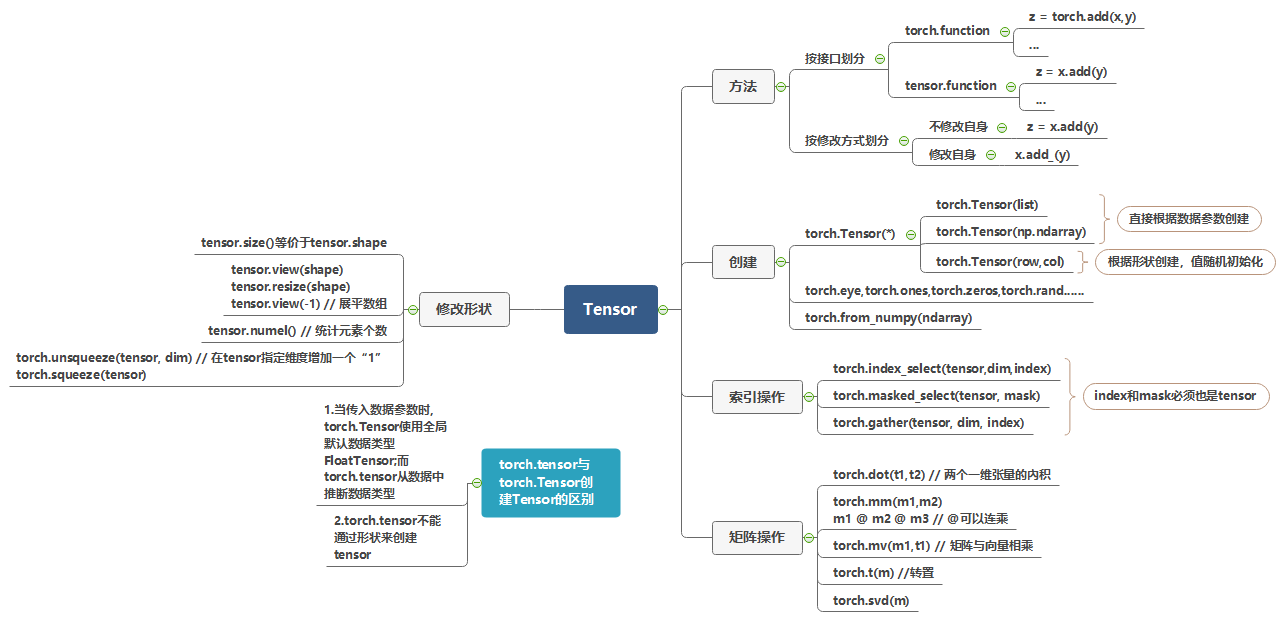

# 反向传播


## 标量反向传播
z = wx + b,其中w,x,b都是标量

In [4]:
import torch

# 定义输入张量x
x = torch.Tensor([2])
# 初始化权重参数w,偏移量b
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
# 前向传播
y = w @ x
z = y + b
# 基于张量z进行梯度反向传播
z.backward() # 当目标张量为标量时，backward()可以无需传入参数
# 因为在执行backward()之后，计算图会自动清空（pytorch的动态图机制使得在每次前向传播时重新构建计算图）
# 如果需要多次使用backward（）, 需设置retain_graph=True,此时梯度是累加的
# z.backward(retain_graph=True)
print("参数w,b,x的梯度分别为：{}，{}, {}".format(w.grad, b.grad, x.grad)) # x无需求导
print("非叶子节点y,z的梯度分别为:{},{}".format(y.grad, z.grad)) #backward之后，非叶子节点的梯度自动清空

参数w,b,x的梯度分别为：tensor([2.])，tensor([1.]), None
非叶子节点y,z的梯度分别为:None,None


## 非标量反向传播
pytorch有个规定：不允许张量对张量求导，只允许标量对张量求导,
因此，如果loss是张量的话，在调用backward方法时，需要传入gradient参数，
这个参数也是一个张量，并且与loss的形状相同。
假设loss=[l1,l2,l3]，则gradient=[g1,g2,g3]，
在进行求导时，其实是对$loss*grandient^T$这个标量进行求导

In [10]:
import torch

x = torch.tensor([[1,2]], dtype=torch.float, requires_grad=True) # 定义需要求导的叶子节点,x1=1,x2=2
y = torch.zeros(1,2)
y[0, 0] = x[0, 0] ** 2 + 3 * x[0, 1] # y1 = x1^2 + 3 * x2
y[0, 1] = x[0, 1] ** 2 + 2 * x[0, 0] # y2 = x2^2 + 2 * x1

J = torch.zeros(2,2) # 初始化雅克比矩阵
y.backward(gradient=torch.tensor([[1,0]], dtype=torch.float), retain_graph=True)
J[0] = x.grad
x.grad = torch.zeros_like(x.grad) # 当设置retain_graph为True时，梯度是累加的，因此需要清零
y.backward(gradient=torch.tensor([[0,1]], dtype=torch.float))
J[1] = x.grad
print(J)

tensor([[2., 3.],
        [2., 4.]])


上述代码的结果是
$$
\left[
\begin{matrix}
\frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} \\
\frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2}
\end{matrix}
\right]
$$

# pytorch神经网络工具箱
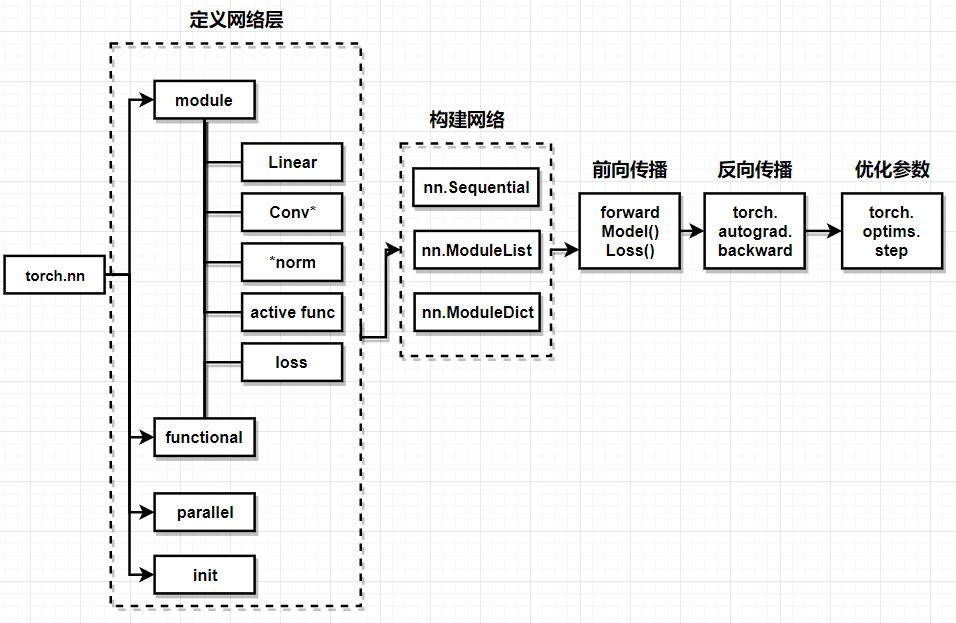
***
由上图可知，构建网络层可以基于module模块中的层，例如nn.Linear或者functional模块中的层，module中的大多数层在functional中都有与之对应的函数。  
两者的主要区别在于module中的层继承了Module类，会自动提取可学习的参数，而functional中的层更像纯函数。但是两者功能相同，性能也没多大区别。

**那么在构建网络层时该如何选择呢？**   
像卷积层、全连接层、Dropout层因为含有可学习参数，所以一般使用module模块中的层;像激活函数、池化层等不含可学习参数，一般使用functional中的函数。
